## WRITE UP
### In this assignment, 
#### First, there are 4 functions to load and process data. Then we get the overall dataframe df. In each plot, we will still make some modifications to the dataframe to suit the specific problem/plot we are interested.
#### In each plotting, after getting the adjusted dataframe, the plotting are done in a function that can be also used with other dataframes. There are many interesting and even unpredicted results from the plots, which I put down after each plot.
#### As for the plot selection, each plot addresses one or some questions that are mostly focusing on financial structure of different institutions (either private or public; or either in California or Illinois).


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import bokeh
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from ipywidgets import interact, interact_manual
from bokeh.transform import cumsum
from bokeh.palettes import Category10, brewer
from ipywidgets import RadioButtons

In [2]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
PATH = r'D:\uchi\Fall\PPHA30536_Data and Programming for Public Policy II\homework-3-luotianling327'

In [4]:
def data_loading(fname):
    df = pd.read_csv(os.path.join(PATH, fname))
    return df

In [5]:
def drop_columns(df,drop_list):
    column_list = df.columns
    df_dropped = df
    for integer in drop_list:
        df_dropped = df_dropped.drop(column_list[integer], axis=1)
    return df_dropped

In [6]:
def df_separate(df,column_name,value1,value2):
    df1 = df.loc[df[column_name] == value1]
    df2 = df.loc[df[column_name] == value2]
    return df1, df2

In [7]:
def remove_nan(df,column_list):
    for col in column_list:
        df = df[df[col].notna()]
    return df

In [8]:
df = data_loading('EducationDataPortal_10.24.2021_institutions.csv')

## 1st static plot

In [9]:
df_rev_exp = drop_columns(df,[1,5,7,8,9,10,11,12])
df_rev = remove_nan(df_rev_exp,['rev_tuition_fees_gross'])
df_rev_mean = df_rev.groupby(['year', 'inst_control']).mean()
df_rev_mean.reset_index(level=['year', 'inst_control'], inplace=True)
df_private, df_public = df_separate(df_rev_mean,'inst_control','Private not-for-profit','Public')

In [10]:
def plot_double_lines(df_1,df_2,label_1,label_2,title):
    fig, ax = plt.subplots()
    ax.plot(df_1['year'], df_1['rev_tuition_fees_gross'], 'b-', label=label_1)
    ax.plot(df_2['year'], df_2['rev_tuition_fees_gross'], 'r--', label=label_2)
    ax.set_title(title)
    ax.legend(loc='upper left')
    ax.set_xlabel('year')
    ax.set_ylabel('Revenue: Tuition & Fees');

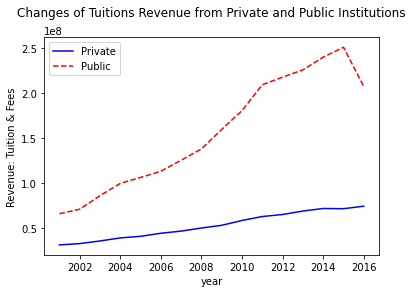

In [11]:
plot_double_lines(df_private,df_public,'Private','Public','Changes of Tuitions Revenue from Private and Public Institutions\n')

#### In this static plot, the trend of private not-for-profit and public institutions' revenue from tuition & fees is shown.
#### The results from this graph are interesting：
1. It is astounding that the public schools actually gain more from tuition and fees, and the gap is increasing (except year 2016)
2. The value for public institutions drops in 2016, while the private instituions show small increases throughout the years.

## 2nd static plot

In [12]:
df_total_rev_exp = remove_nan(df_rev_exp,['total_revenues_additions','total_expenses_deductions'])
df_total_mean = df_rev.groupby(['year']).mean()
df_total_mean['net_profit'] = df_total_mean['total_revenues_additions'] - df_total_mean['total_expenses_deductions']

In [13]:
def bar_line_plot(df_mean,fs,bar_width):
    ind = np.arange(len(df_mean.index))

    fig, ax = plt.subplots(figsize=(40,32))
    ax.bar(ind,df_mean['total_revenues_additions'],bar_width,label = 'Total Revenues')
    ax.bar(ind + bar_width,df_mean['total_expenses_deductions'],bar_width,label = 'Total Expenses')
    ax.set_title('Changes of Total Revenues V.S. Total Expenses\n',fontsize=fs+8)
    ax.legend(loc='upper left',fontsize=fs)
    ax.set_xlabel('year',fontsize=fs)
    ax.set_ylabel('Total Revenues v.s. Expenses',fontsize=fs)
    ax.set_xticks(ind + bar_width/2)
    ax.set_xticklabels(df_mean.index,fontsize=fs)
    ax.tick_params(labelsize=fs)
    ax.yaxis.get_offset_text().set_fontsize(fs)

    ax2 = plt.twinx()
    ax2.plot(ind+bar_width/2,df_mean['net_profit'],color='green',linewidth=6.0,label='Net Profit')
    ax2.legend(loc='upper right',fontsize=fs)
    ax2.set_ylim(-1e8,1e8)
    ax2.tick_params(labelsize=fs)
    ax2.yaxis.get_offset_text().set_fontsize(fs);

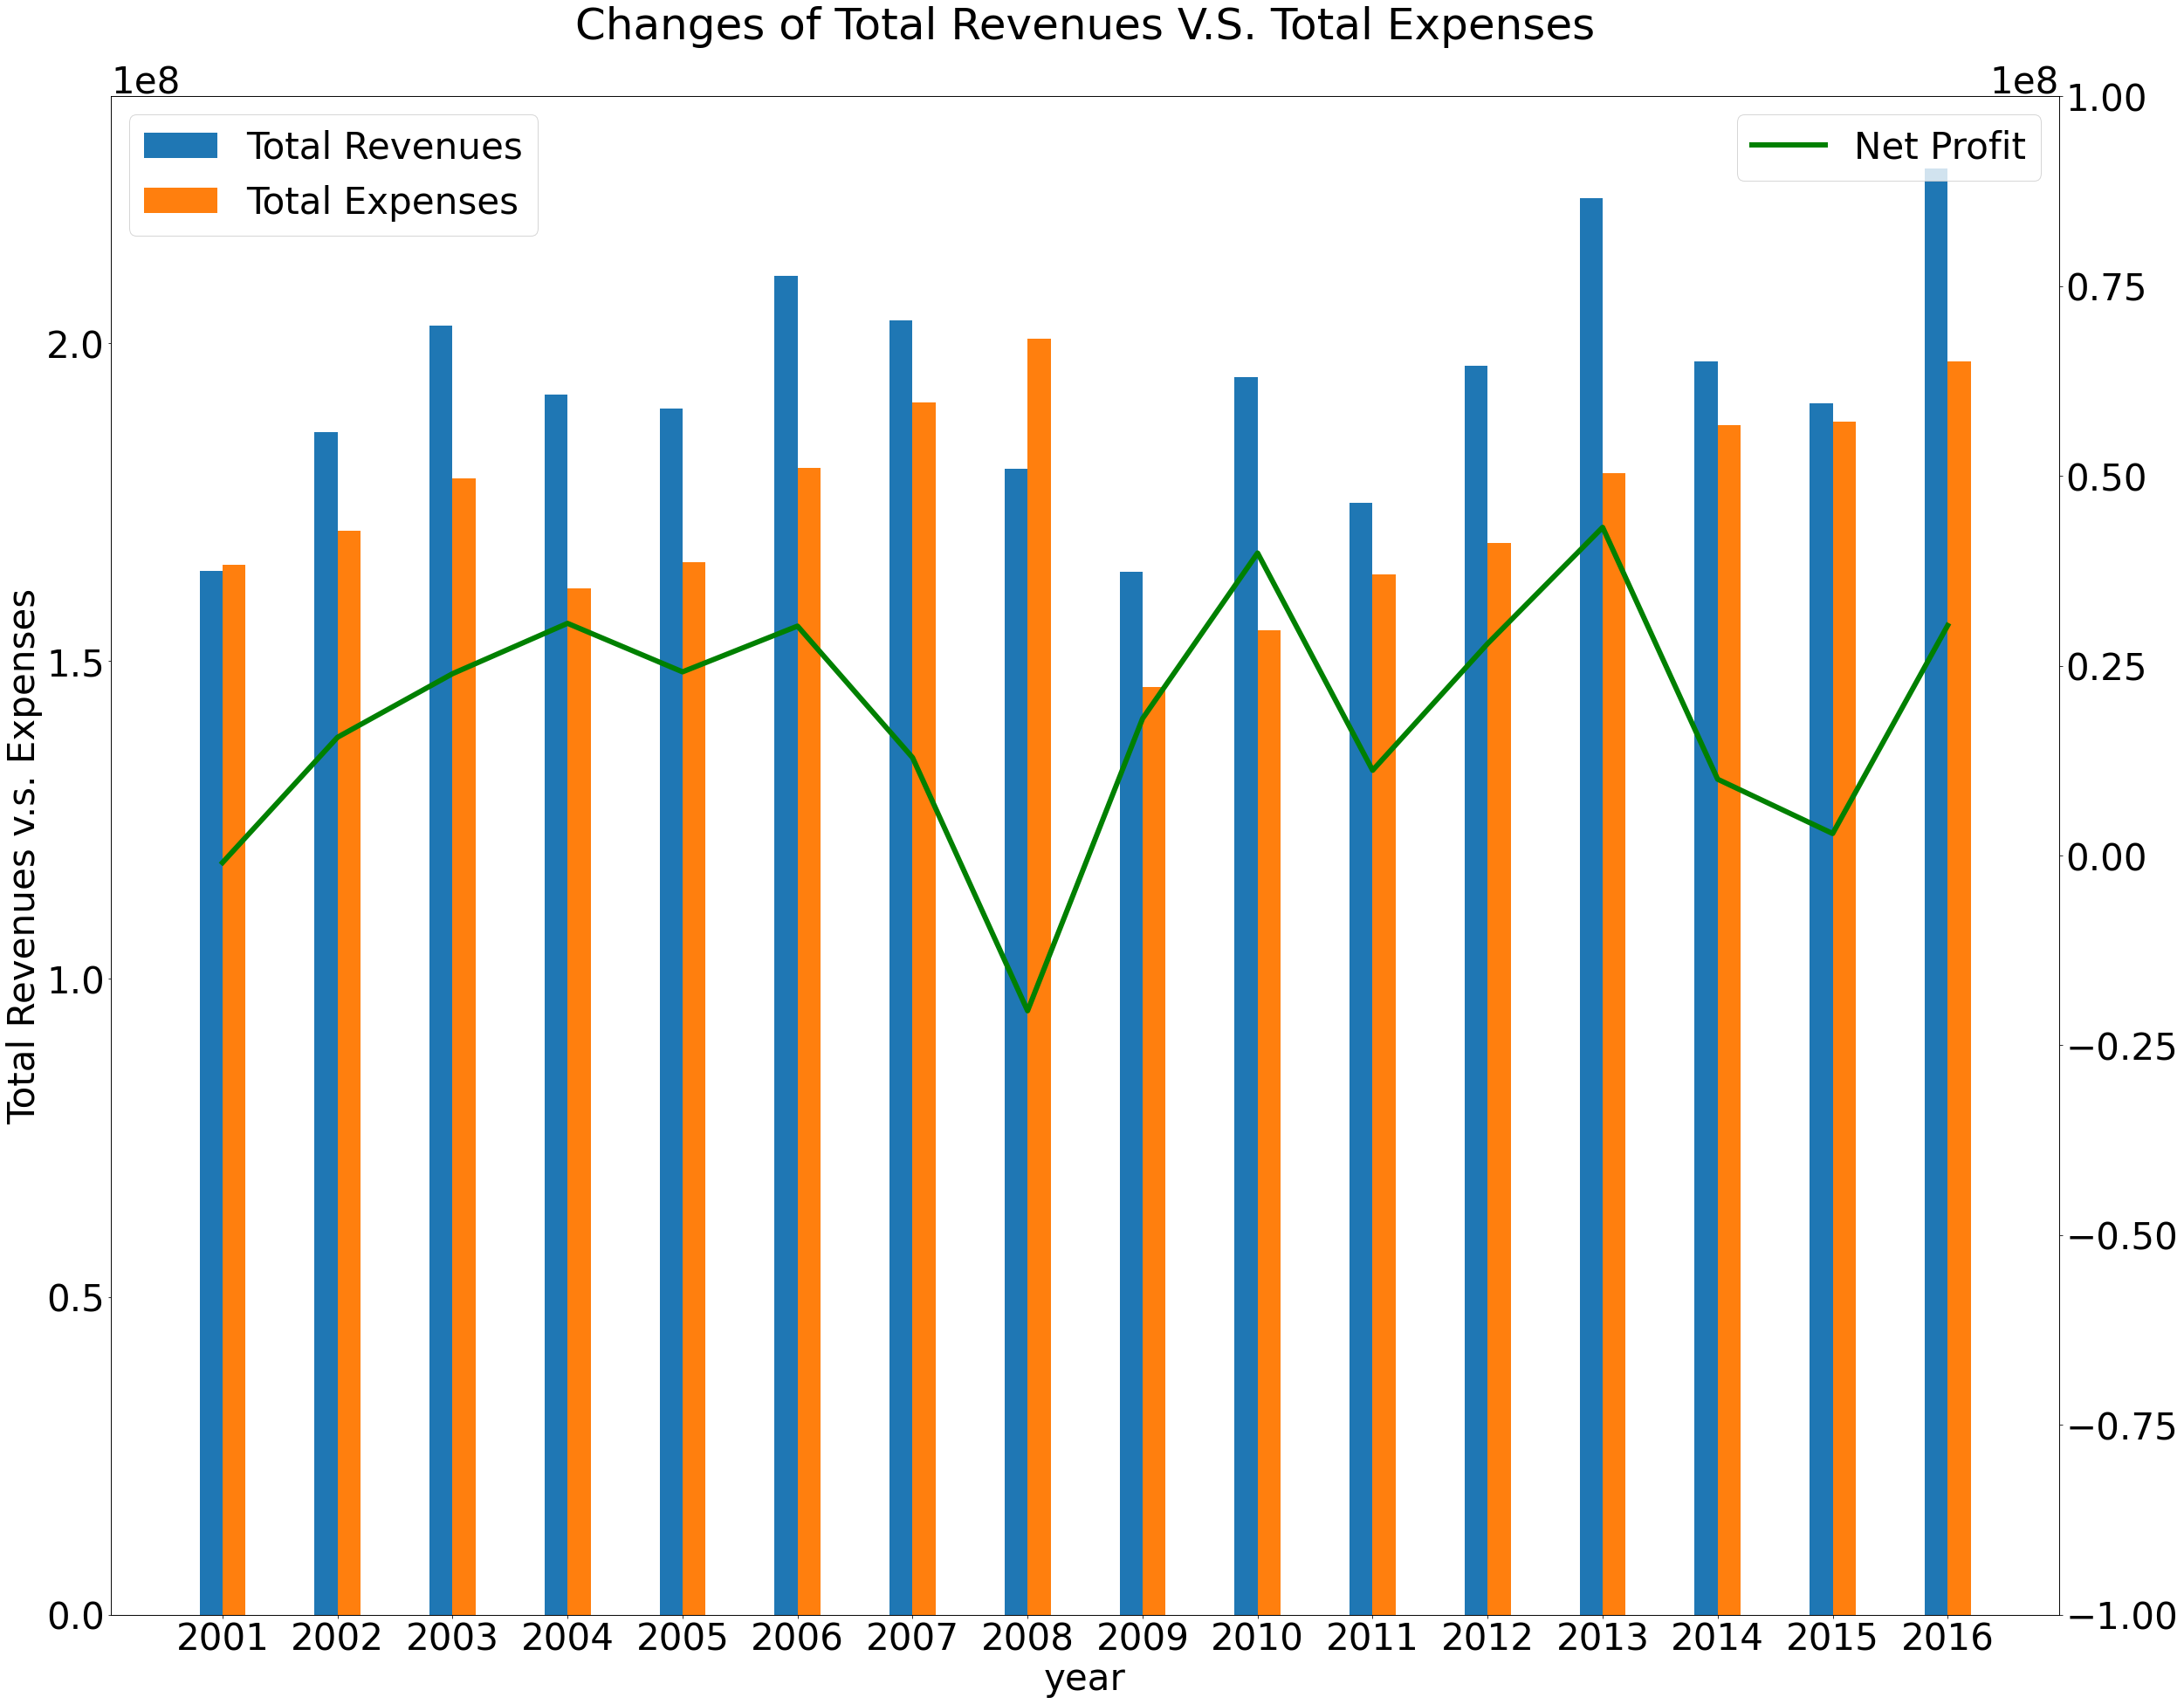

In [14]:
bar_line_plot(df_total_mean, 42, 0.2)

#### In this second static plot, the trend of total revenues and expenses, as well as the net profit (= total revenues - total expenses) are shown.
#### There are several interesting results:
1. The net profit flucturates but is still positive in most years.
2. One particular year that the total expenses reach the peak and the net profit becomes negative to a relatively large extent is 2008, which is exactly the year of financial crisis.

## 1st interactive plot

In [15]:
df_exp = drop_columns(df,[1,5,6,10,11,12,13,14])
df_exp = remove_nan(df_exp,['exp_instruc_total','exp_acad_supp_total'])
df_exp['exp_net_grant_aid_total'] = df_exp['exp_net_grant_aid_total'].fillna(0)

In [16]:
@interact_manual(state=['California', 'Illinois'],years=(2001,2016),inst_type=RadioButtons(options=['Public', 'Private not-for-profit']))
def make_plot(state='California', years=2010, inst_type='Public'):
    assert(state in ['California', 'Illinois']), 'The state selected is not included.'
    assert(inst_type in ['Public', 'Private not-for-profit']), 'The institution type selected is not included.'
    
    df_exp1 = df_exp.loc[(df_exp['state_name'] == state) & (df_exp['inst_control'] == inst_type)]
    df_exp_mean = df_exp1.groupby(['year']).mean()
    
    proportion = df_exp_mean.loc[(df_exp_mean.index == years)].values.tolist()[0]
    proportion = [float(i) for i in proportion]
    proportion = [i/sum(proportion) for i in proportion]
    legend = ['Expenditure: instruction','Expenditure: academic support','Expenditure: net scholarships and fellowship']
    dic = dict(zip(legend,proportion))
    df = pd.Series(dic).reset_index(name='proportion').rename(columns={'index':'name'})
    df['start'] = [i*2*np.pi for i in [0] + proportion[:-1]]
    df['end'] = [i*2*np.pi for i in proportion]
    df['color'] = Category10[len(proportion)]
    
    plot = figure(x_range=(-0.8,0.8), y_range=(-0.8,0.8),title='Proportion of 3 kinds of Expenditures')
    plot.wedge(x=0, y=0, radius=0.5, start_angle=cumsum('start'), end_angle=cumsum('end'), line_color='white',fill_color='color',legend_field='name',source=df)
    plot.axis.visible = False
    plot.axis.axis_label = None
    show(plot)

interactive(children=(Dropdown(description='state', options=('California', 'Illinois'), value='California'), I…

#### In this interative plot, one can get the proportion of three kinds of expenditures - instruction, academic support, and net scholarships and fellowship expenses of a particular year, state, and institution type.
#### However, there are some NaN values in Expenditures: Net scholarships and fellowship expenses which I am not sure if they are not available or 0. In this graph, I consider them as 0.
#### There are several interesting results:
1. Public institutions spend larger proportion in instruction, and lower in net scholarships and fellowship compared to public ones.
2. The expenditure on instuction is larger than academic support, and even larger than scholarships and fellowship.

## 2nd interactive plot

In [17]:
df_asset = drop_columns(df,[1,5,6,7,8,9,13,14])
df_asset = remove_nan(df_asset,['assets','liabilities'])
df_asset['equities'] = df_asset['assets'] - df_asset['liabilities']

In [18]:
@interact_manual(state=['California', 'Illinois'], inst_type=RadioButtons(options=['Public', 'Private not-for-profit']))
def make_plot(state='California', inst_type='Public'):
    assert(state in ['California', 'Illinois']), 'The state selected is not included.'
    assert(inst_type in ['Public', 'Private not-for-profit']), 'The institution type selected is not included.'
    
    df_asset1 = df_asset.loc[(df_asset['state_name'] == state) & (df_asset['inst_control'] == inst_type)]
    df_asset_mean = df_asset1.groupby(['year']).mean()
    plot = figure(title='Asset = Liability + Equity')
    legend = ['equities','liabilities']
    plot.varea_stack(stackers=legend, x='year', color=('indianred','lightblue'),legend_label=legend, source=df_asset_mean)
    plot.legend.location = 'top_left'
    show(plot)

interactive(children=(Dropdown(description='state', options=('California', 'Illinois'), value='California'), R…

#### In this interative plot, one can get the trend of proportion of assets, liabilities, and equities of a particular state and type of institutions.
#### There are several interesting results:
1. The equity has a trend of growing, as well as the total assets, while the change in liability is relatively small.
2. One exception is the public institutions of California, whose equity drops and liability increases.